In [1]:
import os 
import json
import sys
from collections import namedtuple
import pandas as pd
import matplotlib.pyplot as plt

Benchmark = namedtuple('Benchmark', 'isPolling iodepth numjobs GenIOPS ActualIOPS P99_lat cpu_idleness')
NumJobs = [1]
IODepth = [1, 4, 8, 16]
IOPS = (100000, 200000, 300000, 400000, 500000, 600000, 700000)

entries = os.listdir("./")
json_files = [f for f in entries if f.endswith("json")]
benchmark_record = []

for file in json_files:
    with open(file) as fd:
        try:
            dd = json.load(fd)
        except:
            sys.stderr.write("error loading json %s" % file, file=sys.stdout)
            exit(1)
    b1 = Benchmark(int(dd["jobs"][0]["job options"]["sqthread_poll"]), \
        int(dd["jobs"][0]["job options"]["iodepth"]), \
        int(dd["jobs"][0]["job options"]["numjobs"]), \
        int(dd["jobs"][0]["job options"]["rate_iops"]), \
        float(dd["jobs"][0]["read"]["iops_mean"]), \
        float(dd["jobs"][0]["read"]["clat_ns"]["percentile"]["99.000000"]),\
        float(dd["cpu_idleness"]["system"])
        )
    benchmark_record.append(b1)

df = pd.DataFrame(benchmark_record)
df["CPU_util"] =  100 - df["cpu_idleness"]
df["iops_per_cpuutil"] =  df["ActualIOPS"] / df["CPU_util"] 

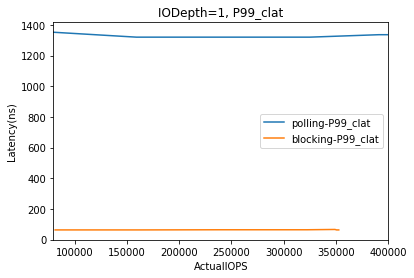

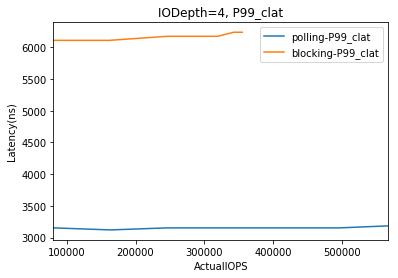

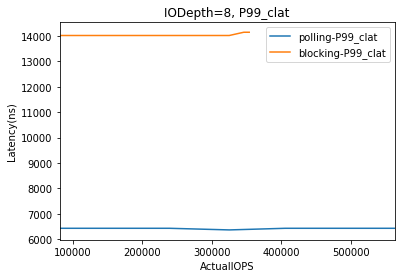

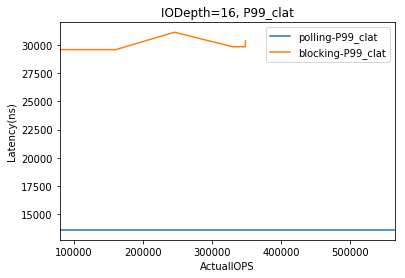

In [3]:
for iod in IODepth:
    blocking=df[(df["isPolling"]==0)&(df["iodepth"]==iod)]
    blocking=blocking.sort_values(by="ActualIOPS")

    polling=df[(df["isPolling"]==1)&(df["iodepth"]==iod)]
    polling=polling.sort_values(by="ActualIOPS")
    
    ax = polling.plot.line(x="ActualIOPS",y="P99_lat",label="polling-P99_clat")
    blocking.plot.line(x="ActualIOPS",y="P99_lat",ax=ax, label="blocking-P99_clat")
    ax.set_title(label="IODepth=%d, P99_clat" % (iod))
    ax.set_ylabel("Latency(ns)")

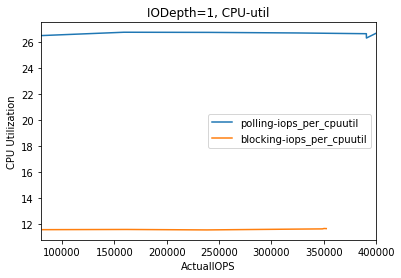

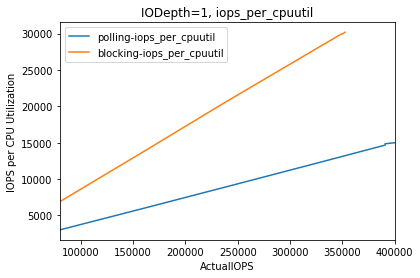

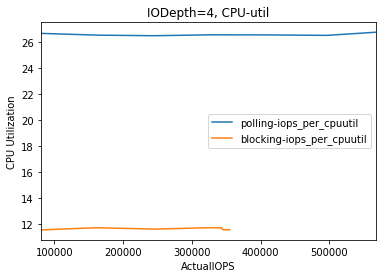

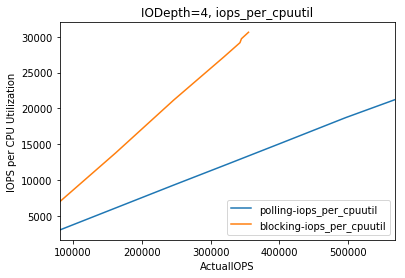

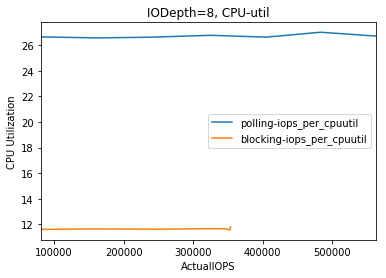

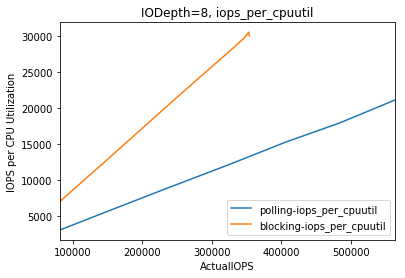

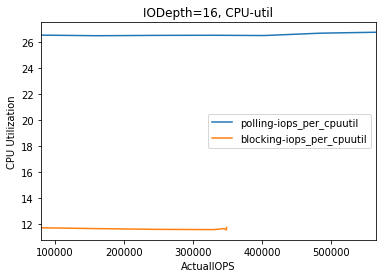

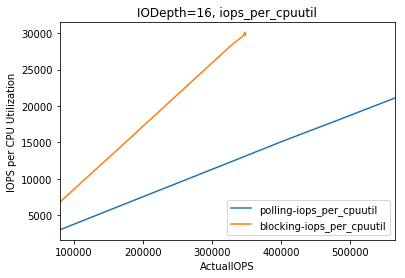

In [2]:
for iod in IODepth:
    blocking=df[(df["isPolling"]==0)&(df["iodepth"]==iod)]
    blocking=blocking.sort_values(by="ActualIOPS")

    polling=df[(df["isPolling"]==1)&(df["iodepth"]==iod)]
    polling=polling.sort_values(by="ActualIOPS")

    
    ax1 = polling.plot.line(x="ActualIOPS",y="CPU_util",label="polling-iops_per_cpuutil")
    blocking.plot.line(x="ActualIOPS",y="CPU_util",ax=ax1, label="blocking-iops_per_cpuutil")
    ax1.set_title(label="IODepth=%d, CPU-util" % (iod))
    ax1.set_ylabel("CPU Utilization")

    ax2 = polling.plot.line(x="ActualIOPS",y="iops_per_cpuutil",label="polling-iops_per_cpuutil")
    blocking.plot.line(x="ActualIOPS",y="iops_per_cpuutil",ax=ax2, label="blocking-iops_per_cpuutil")
    ax2.set_title(label="IODepth=%d, iops_per_cpuutil" % (iod))
    ax2.set_ylabel("IOPS per CPU Utilization")    